In [2]:
#we have different CNN layers and optional activation functions followed by
#so called pooling layers and these layers are used to automatically learn
#some features from the images and then at the end, we have one or more
#fully connected layers for the actual classification tasks and these
#convolutional filter work by applying a filter kernel to our image
#so we put the kernel at the first position in our image and then we compute
#the output value by multiplying and summing up all the values and then we write
#the value at the output image and then slide our filter to our next position
#initial image*filter = resulting image
#Max pooling - downsample an image by applying a maximum filter to separations

Files already downloaded and verified
Files already downloaded and verified


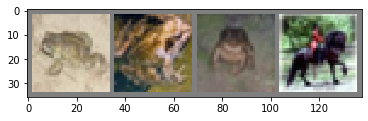

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
)
Epoch [1/5], Step [2000/12500], Loss: 2.3105
Epoch [1/5], Step [4000/12500], Loss: 2.2859
Epoch [1/5], Step [6000/12500], Loss: 2.2864
Epoch [1/5], Step [8000/12500], Loss: 2.3259
Epoch [1/5], Step [10000/12500], Loss: 2.2731
Epoch [1/5], Step [12000/12500], Loss: 2.2821
Epoch [2/5], Step [2000/12500], Loss: 2.0504
Epoch [2/5], Step [4000/12500], Loss: 1.9463
Epoch [2/5], Step [6000/12500], Loss: 1.9085
Epoch [2/5], Step [8000/12500], Loss: 2.0707
Epoch [2/5], Step [10000/12500], Loss: 1.9582
Epoch [2/5], Step [12000/12500], Loss: 1.5564
Epoch [3/5], Step [2000/12500], Loss: 1.5130
Epoch [3/5], Step [4000/12500], Loss: 1.5194
Epoch [3/5], Step [6000/12500], Loss: 1.5478
Epoch [3/5], Step [8000/12500], Loss: 1.7882
Epoch [3/5], Step [10000/12500], Loss: 1.2136
Epoch [3/5], St

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 5
batch_size = 4
learning_rate = 0.001

# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)#(input_channels,output_channels,kernel_channels)
        #images have 3 color channels
        #let's say output size is 6 and kernel size is 5
        #[4, 3, 32, 32]
        #[4,6,28,28] - image size 28x28 ((W-F+2P)/S)+1 = ((32-5+0))/1 + 1 = 28
        self.pool = nn.MaxPool2d(2, 2)
        # ((28-2)/2)+1 = 14 (Stride 2 Kernel size 2)
        #pooling layer with kernel size of 2x2 and stride of 2(shifted pixels by 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        #(14-5)/1+1 = 10, [4,16,10,10] channel output size 16, resulting image 10x10
        #second conv layer input must be last conv layer output and let's say output is 16
        #kernel size is still 5
        #one more pool here would make the size [4,16,5,5]
        #16x5x5 is the output finally
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        
        self.fc2 = nn.Linear(120, 84)
        #120 input features, 84 output features
        self.fc3 = nn.Linear(84, 10)
        #84 input size, output size is 10 becoz we have 10 different classes

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400 #tensor flatten - dimension reduced to 2d instead of 4d
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x


model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # batch size - 4, 3 different color channels
        # 32x32 images size
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        #
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

with torch.no_grad(): #don't need backward propagation and gradient calculations
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')
